In [1]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

In [2]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs = [-0.5], observables=[qml.PauliZ(0)])

In [3]:
# Global Parameters
Tau_global = torch.tensor(0)   # Dephase tau
Gamma_ps_global = torch.tensor(0)
Paras_global = torch.tensor([0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [4]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    """ 
    Construct a quantum circuit with specified gates and operations.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Density matrix of the quantum system after applying gates.
    """
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z = Paras_global[1]
    
    gamma_dephase = Dephase_factor(Tau_global)  

    qml.RX(torch.pi/2, wires = 0)

    qml.ApproxTimeEvolution(H, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0) 

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

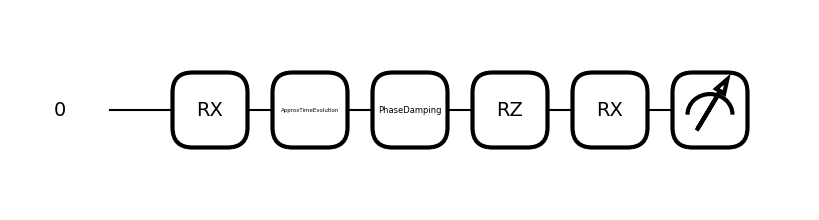

In [5]:
fig, ax = qml.draw_mpl(circuit)(1)

In [6]:
# mem = circuit(np.pi)
# rho = qml.QubitDensityMatrix(mem, wires=0)

# gamma_temp = torch.tensor([0])
# gamma_temp_2 = 0

# K = torch.tensor([
#         [torch.sqrt(1 - gamma_temp), 0],
#         [0, 1]
#     ], dtype=torch.complex128)

# K_1 = np.array([
#     [np.sqrt(1 - gamma_temp_2), 0],
#     [0, 1]
#     ])

# # print(rho.dtype)
# print(mem.dtype)
# print(K.dtype)
# print(K_1.dtype)

# mem

In [7]:
# rho

In [8]:
# num = K @ mem @ K.conj().T
# den = torch.trace(num)

In [9]:
# rho_ps = num / den

# print(rho_ps.dtype)

# rho_ps

In [10]:
# @qml.qnode(dev, interface='torch', diff_method='backprop')
# def test_circuit(phi):
    
#     qml.QubitDensityMatrix(rho_ps, wires=0)
    
#     return qml.density_matrix(wires=0)

# phi_test = torch.tensor([torch.pi])

# test_circuit(phi_test)

In [11]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def Post_selection(phi):
    """ 
    Perform post-selection on the output of the `circuit` function.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Post-selected density matrix after applying a Kraus operator.
    """
    global Paras_global, Gamma_ps_global

    get_density_matrix = circuit(phi)    
    # Kraus operator for 2*2 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0],
        [0, 1]
    ], dtype=torch.complex128)

    Numerator = K @ get_density_matrix @ K.conj().T
    Denominator = torch.trace(Numerator)
    rho_ps = Numerator / Denominator

    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

In [12]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor([desired_gamma_post_selection])

In [13]:
# phi_test = torch.tensor([5.0], requires_grad=True)
# # Gamma_ps_global = torch.tensor([0])

# Post_selection(phi_test)

In [14]:

# cfi = qml.qinfo.classical_fisher(Post_selection)(phi_test)

# cfi

In [15]:
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

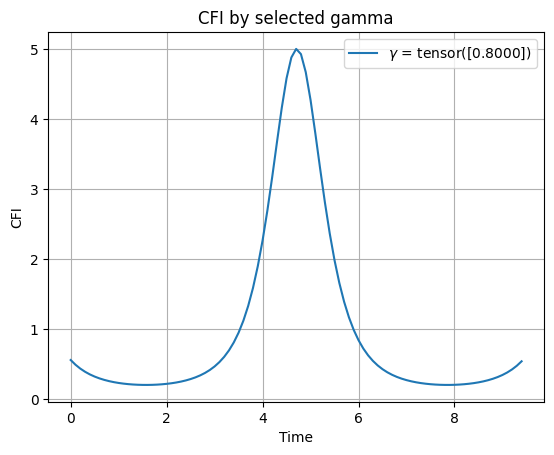

In [16]:
def plot_test():
    global Paras_global
    # set circuit
    set_circuit(0, 0.8)
    Paras_global = torch.tensor([torch.pi/2, torch.pi/2])
    
    PHI = torch.arange(0, 3*torch.pi, 1e-1)
    Data_temp = torch.zeros((len(PHI), 2))
    Data_temp[:, 0] = PHI

    for idx, phi_current in enumerate(PHI):
        phi_temp = torch.tensor([phi_current])
        Data_temp[idx][1] = qml.qinfo.classical_fisher(Post_selection)(phi_temp)

    Data_temp = Data_temp.detach().numpy() 
    
    plt.plot(Data_temp[:,0], Data_temp[:,1], label = f'$\gamma$ = {Gamma_ps_global}')

    plt.title('CFI by selected gamma')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid()
    
plot_test()

In [17]:
# phi = torch.arange(0,to)

In [18]:
def primative():
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # params_t = torch.tensor([np.pi/2, np.pi/3], requires_grad=True, device=device)
    # params_t = torch.tensor(params, requires_grad=True, device=torch.device('mps'))

    # params_t = params_t.detach().clone().requires_grad_(True)

    # params_t = torch.tensor([np.pi/3, np.pi/3], requires_grad=True)

    params_t = torch.tensor([1.0, torch.pi/2], requires_grad=True)

    Circuit_select_global = Post_selection
    Phi_global = torch.tensor([torch.pi*2])

    # opt = torch.optim.LBFGS([params_t])
    # opt = torch.optim.Adam([params_t])
    opt = torch.optim.LBFGS(
        [params_t], 
        lr=0.01,              # Learning rate
        max_iter=20,          # Maximum number of iterations per optimization step
        max_eval=None,        # Maximum number of function evaluations per optimization step
        tolerance_grad=1e-7,  # Termination tolerance on the gradient norm
        tolerance_change=1e-9,# Termination tolerance on the function value/parameter changes
        history_size=100      # Update history size
    )

    steps = 500

    f_logs = [cost_function(params_t).item()]
    ftol = 1e-10

    def closure():
        opt.zero_grad()
        loss = cost_function(params_t)
        loss.backward()
        return loss

    for i in range(steps):
        opt.step(closure)
        fval = cost_function(opt.param_groups[0]['params'][0]).item()
        print(f"{i+1:03d}th iteration, CFI=", fval)
        f_logs.append(fval)
        if np.abs((fval-f_logs[-2])/fval) < ftol:
            break
        
    print("CFI=", fval, "Paras=", opt.param_groups[0]['params'][0].detach().numpy())

In [19]:
def torch_optimization(sweep_range, initial_parameters, method):
    """ 
    Perform optimization using specified optimizer over a range of phi values.

    Args:
        sweep_range (list): Range of phi values for optimization.
        initial_parameters (torch.Tensor): Initial parameters for optimization.
        method (str): Optimization method ('LBFGS' or 'Adam').

    Returns:
        torch.Tensor: Data tensor containing optimization results.
    """
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    if method == 'LBFGS':
        opt = torch.optim.LBFGS(
                [params_tensor], 
                lr=0.01,              # Learning rate
                max_iter=20,          # Maximum number of iterations per optimization step
                max_eval=None,        # Maximum number of function evaluations per optimization step
                tolerance_grad=1e-7,  # Termination tolerance on the gradient norm
                tolerance_change=1e-9,# Termination tolerance on the function value/parameter changes
                history_size=100      # Update history size
        )
    elif method == 'Adam':
        opt = torch.optim.Adam(
            [params_tensor],
            lr=0.001,                # Learning rate (default: 0.001)
            betas=(0.9, 0.999),      # Coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
            eps=1e-08,               # Term added to the denominator to improve numerical stability (default: 1e-8)
            weight_decay=0,          # Weight decay (L2 penalty) (default: 0)
            amsgrad=False            # Whether to use the AMSGrad variant of this algorithm (default: False)
        )
    else:
        raise ValueError("Invalid optimizer choice.")
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 1
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-10
        
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            # print(f"{i+1:03d}th iteration, CFI=", fval)
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        print("CFI =", -fval, "Paras =", opt.param_groups[0]['params'][0].detach().numpy())
        
        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]
        
        # torch.cat(([-fval], opt.param_groups[0]['params'][0].detach().numpy()))


    return Data

In [20]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """ 
    Iterate over different values of tau_dephase and gamma_post_selection for optimization.

    Args:
        sweep_range (list): Range of phi values for optimization.
        init_par (torch.Tensor): Initial parameters for optimization.
        tau_dephase (list): List of dephasing rates tau to iterate over.
        gamma_post_selection (float): Post-selection rate gamma.
        method (str): Optimization method.

    Returns:
        np.ndarray: Numpy array with optimization results for each tau.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = torch_optimization(sweep_range, init_par, method).detach().cpu().numpy()
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [28]:
class Index(Enum):
    PHI = 0
    CFI = 1
    PARAS_START = 2
    THETA_X = 2
    PHI_Z = 3
    TAU_1 = 4
    TAU_2 = 5

def plot_result(result_data, tau_dephase, gamma_ps_select, object):
    """ 
    Plot the results of the optimization.

    Args:
        result_data (np.ndarray): Data from optimization.
        tau_dephase (list): List of dephasing rates tau used in optimization.
        object (str): Type of plot ('CFI', 'theta_x', or 'phi_z').

    """
    if object == 'CFI':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.CFI.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.title(f'Optimized CFI at $\gamma_{{ps}} = {gamma_ps_select}$')
        plt.xlabel('Time')
        plt.ylabel('CFI')
        plt.grid()
        plt.legend()
        plt.show()
        
    elif object == 'theta_x':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.THETA_X.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.yticks(
            [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
            ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
        )
        plt.ylim(0, np.pi)

        plt.title(f'Optimized $\\theta_{{x}}$')
        plt.xlabel('Time')
        plt.ylabel('RAD')
        plt.grid()
        plt.legend()
        plt.show()
        
    elif object == 'phi_z':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.PHI_Z.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.yticks(
            [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
            ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
        )
        # plt.ylim(-np.pi, 2*np.pi)

        plt.title(f'Optimized $\\phi_{{z}}$')
        plt.xlabel('Time')
        plt.ylabel('RAD')
        plt.grid()
        plt.legend()
        plt.show()

In [22]:
sweep_range = torch.tensor([0.0, 3*torch.pi, 1e-2], dtype=torch.float)
init_par = torch.tensor([torch.pi/2, torch.pi/2])
tau_dephase = 0, 5e-2, 2e-1, 5e-1, 1, 2, 3, 4
# tau_plot = 0, 5e-2, 2e-1, 5e-1, 1, 2, 3, 4

gamma_ps = 0.8

res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGS')

CFI = 0.710154836057056 Paras = [1.5707964 1.7449579]
CFI = 1.0628710946854136 Paras = [1.5707964 2.0093296]
CFI = 2.7614927524174098 Paras = [1.5707964 2.5649107]
CFI = 4.434817007192941 Paras = [1.5699289 2.9223447]
CFI = 4.649408160189268 Paras = [1.5704207 2.9889004]
CFI = 4.762477690981549 Paras = [1.5706118 3.0344832]
CFI = 4.830540750192749 Paras = [1.5707085 3.0696297]
CFI = 4.87424889073025 Paras = [1.5707475 3.0983183]
CFI = 4.903826772099004 Paras = [1.5707738 3.1227686]
CFI = 4.924180390176016 Paras = [1.5707872 3.14399  ]
CFI = 4.938485901166675 Paras = [1.5707927 3.1627765]
CFI = 4.94877291669338 Paras = [1.5707941 3.1797273]
CFI = 4.95628905573033 Paras = [1.5707958 3.1952486]
CFI = 4.96186216359961 Paras = [1.5707955 3.209649 ]
CFI = 4.966115976693938 Paras = [1.5707972 3.2232246]
CFI = 4.9693453907899 Paras = [1.570796  3.2360916]
CFI = 4.97181795050463 Paras = [1.5707968 3.2483878]
CFI = 4.973729279859121 Paras = [1.5707959 3.2602303]
CFI = 4.975207713311383 Paras = [

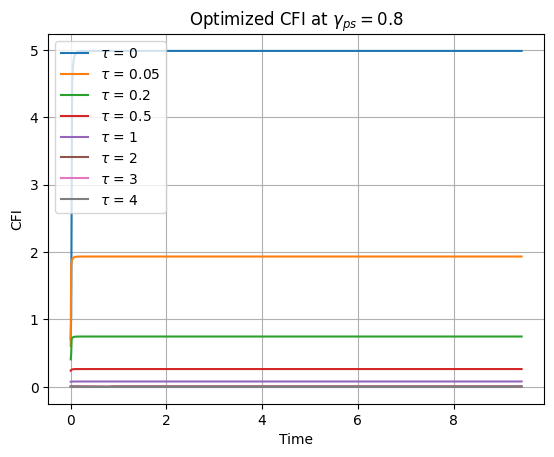

In [23]:
plot_result(res, tau_dephase, gamma_ps, 'CFI')

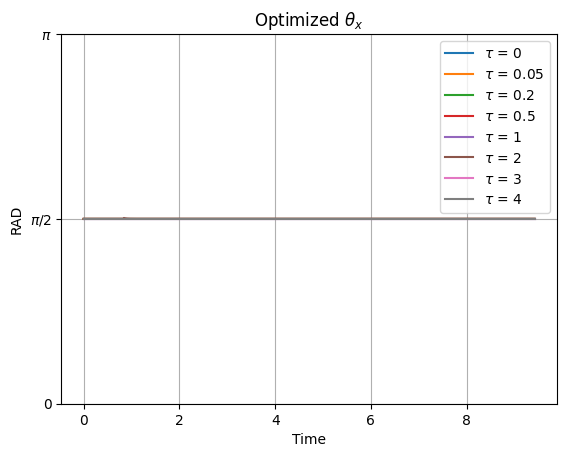

In [29]:
plot_result(res, tau_dephase, gamma_ps, 'theta_x')

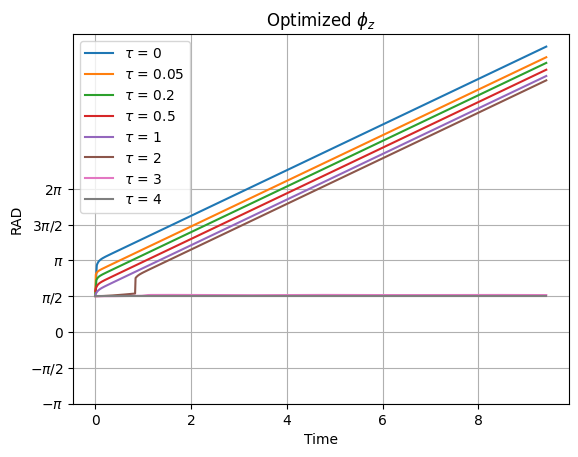

In [25]:
plot_result(res, tau_dephase, gamma_ps, 'phi_z')

In [26]:
print (torch.__version__) 
print(torch.backends.mps.is_built()) 
print(torch.backends.mps.is_available())
!python -c 'import platform;print(platform.platform())'

2.0.1
True
True
macOS-14.1-arm64-arm-64bit
